# Comparison with SNPs3D
SNPs3D is one of a few methods for variant pathogenicity prediction that explicitly takes into account the impact of an amino acid substitution on a protein's stability. In this tutorial, we will compare SNPs3D and Rhapsody's predictions on a relatively small set of SAVs for which we were able to find precomputed predictions for SNPs3D.

In [1]:
import os
import re
import gzip
import glob
import numpy as np
import pandas as pd
import prody

In [2]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

In [3]:
# import the numpy structured array containing precomputed features 
# for the optimized training dataset
ID = np.load('../1-Training_Dataset/local/data/precomputed_features-ID_opt.npy')

## Importing SNPs3D dataset of precomputed predictions
A file containing precomputed predictions for many non-synonymous SNPs can be downloded from [http://www.snps3d.org/download/](http://www.snps3d.org/download/). 
In this tutorial, we will select predictions for SAVs also found in Rhapsody's Integrated Dataset and we will compare their predictions.

In [4]:
if not os.path.isdir('local'):
    os.mkdir('local')

In [5]:
# download file    
gz_file = 'local/snp_analysis_result.txt.gz'
if not os.path.isfile(gz_file):
    import subprocess
    command = 'wget -P local/ http://www.snps3d.org/download/snp_analysis_result.txt.gz'
    subprocess.run(command.split())

In [6]:
# import dataset
snps3d_dataset = pd.read_csv(gz_file, sep='\t')

In [7]:
snps3d_dataset.drop_duplicates(
    subset=['snp_id'],keep=False, inplace=True)
snps3d_dataset.reset_index(drop=True, inplace=True)

In [8]:
snps3d_dataset.head(5)

,locus_ac,seq_ac,snp,control_type,snp_id,svm_profile,svm_structure,rule_description,freq
0,85446,NP_207646,S1082R,population,223124,0.206083,NaN,NaN,NaN
1,3949,LDLR,C646Y,FN,CM900159 143890,-3.334460,-1.14321,OverPacking ss,NaN
2,55040,NP_060427,T544P,population,4794159,1.444760,NaN,NaN,NaN
3,57057,NP_065150,S29F,population,13237089,0.784761,NaN,NaN,NaN
4,81027,NP_110400,Q43H,population,415064,-0.114436,NaN,NaN,0.029412


Here's the description of each column as described on SNPs3D's website:
```
Col1: Entrez Gene ID.
Col2: seq_ac is Refseq protein sequence ID for population SNPs or Gene symbol for control variants.
Col3: snp follows the format of "X123Y", X is wild-type residue, Y is mutant residue, 123 is residue number on protein sequence.
Col4: SNP type includes control (false positive control) and population.
Col5: SNP ID is dbSNP ID for population SNPs.
Col6: svm_profile is svm score assigned by sequence profile model, a negative value indicates a variant is assigned as deleterious.
Col7: svm_structure is svm score assigned by the structure stability model.
Col8: molecular effect is referred to identified structural effect.
Col9: population frequency is based on dbSNP.
```

We will only consider predictions for SAVs that are also included in Rhapsody's Integrated Dataset. In order to do so, RefSeq protein sequence IDs in SNPs3D dataset must be converted to Uniprot accession numbers. We will use a script for [database identifier mapping](https://www.uniprot.org/help/api_idmapping) provided by Uniprot.

In [9]:
snps3d_refseq_list = ' '.join(snps3d_dataset.seq_ac.unique())

In [10]:
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uploadlists/'

params = {
    'from': 'P_REFSEQ_AC',
    'to': 'ACC',
    'format': 'tab',
    'query': snps3d_refseq_list
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
    response = f.read()
content = response.decode('utf-8')

# import mapped list as a dataframe
from_refseq_to_Uniprot = pd.DataFrame(
    [line.split('\t') for line in content.split('\n')[1:]],
    columns=['RefSeq', 'Uniprot']
)

from_refseq_to_Uniprot.head(5)

,RefSeq,Uniprot
0,NP_207646,A0A2P1H683
1,NP_207646,B7ZM83
2,NP_207646,B9EK48
3,NP_207646,Q9C0A1
4,NP_060427,Q9H201


We can now map entries between Rhapsody's Integrated Dataset (ID) and SNPs3D dataset.

In [11]:
ID_SAVs = {}
for idx, SAV in enumerate(ID['SAV_coords']):
    Uniprot_acc = SAV.split()[0]
    ID_SAVs.setdefault(Uniprot_acc, {})
    ID_SAVs[Uniprot_acc][SAV] = idx

# find unique RefSeq-to-Uniprot mapping for proteins in 
# Rhapsody's Integrated Dataset
protein_mapping = {}
for i, row in from_refseq_to_Uniprot.iterrows():
    if row.Uniprot in ID_SAVs:
        protein_mapping[row.RefSeq] = row.Uniprot

# map indexes from Rhapsody's ID to SNPs3D
ID_to_snps3d = {}
for snps3d_idx, row in snps3d_dataset.iterrows():
    refseq_id = row.seq_ac
    if refseq_id in protein_mapping:
        Uniprot_acc = protein_mapping[refseq_id]
        wt_aa, pos, mut_aa = row.snp[0], row.snp[1:-1], row.snp[-1]
        SAV = f'{Uniprot_acc} {pos} {wt_aa} {mut_aa}'
        if SAV in ID_SAVs[Uniprot_acc]:
            ID_idx = ID_SAVs[Uniprot_acc][SAV]
            ID_to_snps3d[ID_idx] = snps3d_idx
            
ID_to_snps3d_table = np.array(
    [[i, ID_to_snps3d[i]] for i in sorted(ID_to_snps3d.keys())])
print("SAVs in SNPs3d mapped to Rhapsody's ID:", len(ID_to_snps3d))

SAVs in SNPs3d mapped to Rhapsody's ID: 2649


In [ ]:
# check
for ID_idx, snps3d_idx in ID_to_snps3d_table:
    snps3d_entry = snps3d_dataset.iloc[snps3d_idx]
    snps3d_SAV = protein_mapping[snps3d_entry.seq_ac]
    snps3d_SAV += ' ' + snps3d_entry.snp[1:-1]
    snps3d_SAV += ' ' + snps3d_entry.snp[0]
    snps3d_SAV += ' ' + snps3d_entry.snp[-1]
    assert snps3d_SAV == ID[ID_idx]['SAV_coords'], ''

SNPs3D provides predictions from two models, a **structure stability model** and a **sequence profile model**, see [here](http://www.snps3d.org/help/method.html) for more details. We also compute a **"consensus model"** that in principle should attain a higher accuracy. From the website:

> *A positive SVM score indicates a variant classified as non-deleterious, and a negative score indicates a deleterious case. The larger the score, the more confident the classification. Accuracy is significantly higher for scores greater 0.5 or less than -0.5. For variants that act by affecting protein function rather than stability, the stability model is expected to return a positive (non-deleterious) SVM score, and the profile model a negative (deleterious) score. Classification by the two methods may also differ because of a false negative or false positive return for one of them. Accuracy is significantly higher for the set of cases where both methods agree.*

In [12]:
snps3d_subset = ID_to_snps3d_table[:, 1]

# pathogenicity scores
preds = {}
preds['SNPs3D_profile']   = {
    'score': - snps3d_dataset.iloc[snps3d_subset].svm_profile.to_numpy()}
preds['SNPs3D_structure'] = {
    'score': - snps3d_dataset.iloc[snps3d_subset].svm_structure.to_numpy()}
preds['SNPs3D_consensus'] = {
    'score': (preds['SNPs3D_profile']['score'] + preds['SNPs3D_structure']['score']) / 2}

# pathogenicity classes
for model in preds:
    score = preds[model]['score']
    # negative svm_scores are considered 'deleterious' predictions
    pclass = np.where(score > 0, 'deleterious', 'neutral')
    # invalid predictions
    pclass[np.isnan(score)] = '?'
    preds[model]['path. class'] = pclass

/home/luca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


## Rhapsody predictions from unbiased classifiers

We train unbiased classifiers by excluding previously selected variants from the training dataset.

In [13]:
ID_test = ID[ID_to_snps3d_table[:, 0]]

In [14]:
# list of proteins whose SAVs are included in SNPs3D subset
test_Uniprot_accs = set(
    [SAV.split()[0] for SAV in ID_test['SAV_coords']])
len(test_Uniprot_accs)

1142

In [15]:
# let's exclude those proteins from Rhapsody's training dataset
sel = [SAV.split()[0] not in test_Uniprot_accs for SAV in ID['SAV_coords']]
ID_train = ID[sel]
len(ID_train)

8642

In [16]:
# let's now train unbiased classifiers
folder = 'local/train/'
if not os.path.isdir(folder):
    os.mkdir(folder)

if not os.path.isdir('local/train/full'):
    logfile = os.path.join(folder, 'RF_training.log')
    prody.LOGGER.start(logfile)
    
    for clsf_version in ['full', 'reduced', 'EVmut']:
        # training of the Random Forest classifier on the given set of features
        featset = rd.DEFAULT_FEATSETS[clsf_version]
        sel = ['SAV_coords', 'true_label'] + featset
        rd.trainRFclassifier(ID_train[sel])
        
        # store output files
        _folder = os.path.join(folder, clsf_version)
        os.mkdir(_folder)
        for file in glob.glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(_folder, file))
            
        prody.LOGGER.info('')
    prody.LOGGER.close(logfile)
else:
    print('Precomputed classifiers found.')

Precomputed classifiers found.


In [17]:
# Finally, let's compute predictions
test_SAVs = ID_test['SAV_coords']

for clsf_version in ['full', 'reduced', 'EVmut']:
    trained_clsf = f'local/train/{clsf_version}/trained_classifier.pkl'
    # since precomputed features are already included in the Integrated Dataset,
    # we won't compute them again, but we import them instead
    rh = rd.Rhapsody(test_SAVs, queryPolyPhen2=False)
    rh.importClassifiers(trained_clsf)
    rh.importFeatMatrix(ID_test)
    preds['Rhapsody_' + clsf_version] = rh.getPredictions(
        PolyPhen2=False, EVmutation=False)
    os.remove('rhapsody-features.txt')

@> Imported feature set:
@>    'wt_PSIC' 
@>    'Delta_PSIC' 
@>    'SASA' 
@>    'ANM_MSF-chain' 
@>    'ANM_effectiveness-chain' 
@>    'ANM_sensitivity-chain' 
@>    'stiffness-chain' 
@>    'entropy' 
@>    'ranked_MI' 
@>    'BLOSUM' 
@> Random Forest classifier imported in 0.2s.
@> 1988 predictions computed in 1.3s.
@> Imported feature set:
@>    'wt_PSIC' 
@>    'Delta_PSIC' 
@>    'SASA' 
@>    'ANM_MSF-chain' 
@>    'ANM_effectiveness-chain' 
@>    'ANM_sensitivity-chain' 
@>    'stiffness-chain' 
@>    'BLOSUM' 
@> Random Forest classifier imported in 0.2s.
@> 2625 predictions computed in 1.2s.
@> Imported feature set:
@>    'wt_PSIC' 
@>    'Delta_PSIC' 
@>    'SASA' 
@>    'ANM_MSF-chain' 
@>    'ANM_effectiveness-chain' 
@>    'ANM_sensitivity-chain' 
@>    'stiffness-chain' 
@>    'entropy' 
@>    'ranked_MI' 
@>    'BLOSUM' 
@>    'EVmut-DeltaE_epist' 
@> Random Forest classifier imported in 0.2s.
@> 1383 predictions computed in 1.2s.


## Comparison

In [18]:
# compute accuracy metrics and other info
metrics = {}

pclass_mapping = {
    'deleterious': 1, 'prob.delet.': 1,
    'neutral': 0, 'prob.neutral': 0,
    '?': -1}

for model in ['SNPs3D_profile', 'SNPs3D_structure', 'SNPs3D_consensus',
              'Rhapsody_full', 'Rhapsody_reduced', 'Rhapsody_EVmut']:
    true_labels = ID_test['true_label']
    pred_score = preds[model]['score']
    pred_class = np.array([
        pclass_mapping[cl] for cl in preds[model]['path. class']])
    # ignore NaN values
    sel = ~np.isnan(pred_score)
    # compute various metrics
    sm = rd.calcScoreMetrics(true_labels[sel], pred_score[sel])
    cm = rd.calcClassMetrics(true_labels[sel], pred_class[sel])
    metrics[model] = {**sm, **cm, 'n. SAVs': sum(sel), 
                      'n. del. SAVs': sum(true_labels[sel])}

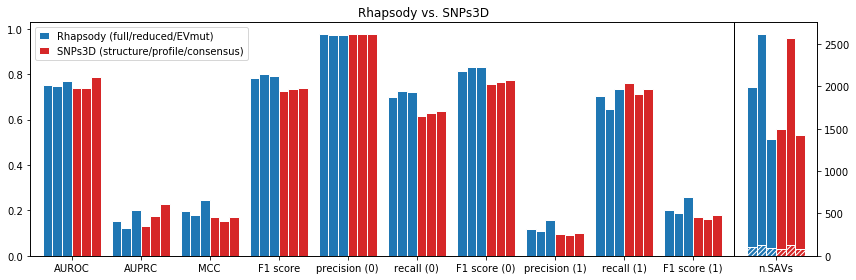

In [19]:
import matplotlib.pyplot as plt

models = [
    'Rhapsody_full', 'Rhapsody_reduced', 'Rhapsody_EVmut',
    'SNPs3D_structure', 'SNPs3D_profile', 'SNPs3D_consensus']
sel_metrics = [
    'AUROC', 'AUPRC', 'MCC', 'F1 score', 
    'precision (0)', 'recall (0)', 'F1 score (0)',
    'precision (1)', 'recall (1)', 'F1 score (1)']

fig, ax = plt.subplots(1, figsize=(12,4))

dx = .14
opts = {'width': dx, 'edgecolor': 'w'}
n = len(sel_metrics)
dn = 0.2

ax.set_title('Rhapsody vs. SNPs3D')
ax.set_xticks(list(range(n)) + [n+dn,])
ax.set_xticklabels([*sel_metrics, 'n.SAVs'])
ax2 = ax.twinx()
ax.set_xlim((-.6, n+.8))

# bar plots
for j, model in enumerate(models):
    x = np.arange(n+1) + (j-3)*dx + dx/2
    d = metrics[model]
    y = [d[sm] for sm in sel_metrics]
    if model.startswith('Rhapsody'):
        c = 'C0'
    else:
        c = f'C3'
    ax.bar(x[:-1], y, color=c, **opts, label=model)
    ax2.bar(x[-1]+dn, d['n. SAVs'], color=c, **opts)
    ax2.bar(x[-1]+dn, d['n. del. SAVs'], color=c, **opts, hatch='/'*5)

# separator
plt.axvline(x=n-.5+dn/2, color='k', linestyle='-', lw=1)

h, l = ax.get_legend_handles_labels()
handles = [h[0], h[3]]
labels = ['Rhapsody (full/reduced/EVmut)',
          'SNPs3D (structure/profile/consensus)']
ax.legend(handles, labels, loc='upper left', handlelength=1)

fig.tight_layout()
fig.savefig('local/figures/SNPs3D_metrics.png', dpi=300);